## DP model using PATE method on MNIST

Secure and Private AI Scholarship Challenge Nanodegree Program

Lession 6: Differential Privacy

Section Project:

For the final project for this section, you're going to train a DP model using this PATE method on the MNIST dataset, provided below.


Current state of this notebook:

I have something for all of the steps that I think need to be taken for the project, but I'm not sure if I'm doing it correctly, especially with respect to the added Laplacian noise and the PATE analysis.

The PATE analysis shows that for 10 teachers, even when there is high agreement, the Data Dependent Epsilon is very similar to the Data Independent Epsilon.

The student model trained on the 1000 queries from each teacher model reaches about 85% accuracy. This could be improved by using GANs, as in the paper "Semi-Supervised Knowledge Transfer for Deep Learning from Private Training Data"

## Steps of the section project:

- Divide MNIST training set into 10 private datasets
- Train 10 different teacher models on these private datasets
- Get the predictions for the test set from each of the 10 models 
- Add some laplacian noise and get a maximum noisy vote 
- Perform pate analysis using the teacher predictions and the max noisy vote as inputs
- Train the student model on some of the test set with labels from the max noisy vote
- Determine the accuracy of the student model on the remainder of the test set

## Links for extra information about the various aspects of the work in this notebook.

#### Pate analysis:

Scalable Private Learning with PATE 

Paper: https://arxiv.org/pdf/1802.08908.pdf

Code: https://github.com/tensorflow/privacy/tree/master/research/pate_2017


Semi-Supervised Knowledge Transfer for Deep Learning from Private Training Data 

Paper: https://arxiv.org/pdf/1610.05755.pdf

#### PySyft:

https://github.com/OpenMined/PySyft/blob/dev/syft/frameworks/torch/differential_privacy/pate.py


#### Mnist:

I adapted the network used for Fashion Mnist from Section 1 of Udacity's Secure & Private AI course:

https://github.com/udacity/private-ai

The adaptations were about how to load the training and test sets, with inspiration from:

https://nextjournal.com/gkoehler/pytorch-mnist


## Imports

In [0]:
import torchvision.datasets as datasets

In [0]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import SubsetRandomSampler

In [0]:
from torch import nn, optim
import torch.nn.functional as F

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

In [5]:
!pip install syft

In [0]:
from syft.frameworks.torch.differential_privacy import pate

In [0]:
import numpy as np

In [0]:
STUDENT_BATCH_SIZE = 100
NUM_TEACHERS = 10
STUDENT_SET_SIZE = 1000

## Training and test set into DataLoaders

Transform ToTensor, and Normalize

Separate out training set into 10 smaller sets

Also return test targets separately, as this may be useful in the analysis

In [0]:
def create_data_loaders (num_training_loaders):

    # Define a transform to normalize the data
    transform=transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))])
    # Download and load the training data
    mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    # Set up the trainloaders list
    trainloaders = []
    data_per_set = int(len(mnist_trainset) / num_training_loaders)
    for i in range(num_training_loaders):
        train_indices = range(i*data_per_set,i*data_per_set+data_per_set)
        trainloaders.append(torch.utils.data.DataLoader(mnist_trainset, 
                                                         batch_size=32, 
                                                         sampler=SubsetRandomSampler(train_indices)))

    # Download and load the test data
    mnist_testset = datasets.MNIST(root='data', train=False, download=True, transform=transform)
    # Set up the testloader
    testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=STUDENT_BATCH_SIZE, shuffle=False)
    test_targets = mnist_testset.test_labels

    return trainloaders, testloader, test_targets

In [10]:
trainloaders, testloader, test_targets = create_data_loaders(NUM_TEACHERS)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## Define Classifier to use for teacher and student models

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

## Create 10 Teacher models

In [0]:
def create_models (num_models):
    # Create the network, define the criterion and optimizer
    models = []
    for i in range(num_models):
        models.append(Classifier())
    
    return models

In [0]:
models = create_models(NUM_TEACHERS)

## Train Teacher models

In [0]:
def train_model (trainloader, model, epochs):

    optimizer = optim.Adam(model.parameters(), lr=0.003)
    criterion = nn.NLLLoss()

    train_losses = []
    for e in range(epochs):
        running_loss = 0
        label_index = 0
        for images, labels in trainloader:
            log_ps = model(images)
            loss = criterion(log_ps, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        else:
            #print(f"Training loss: {running_loss}")
            train_loss = 0
            accuracy = 0
            with torch.no_grad():
                for images, labels in trainloader:
                    log_ps = model(images)
                    train_loss += criterion(log_ps, labels)

                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            train_losses.append(running_loss/len(trainloader))
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Running Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
                  "Train Loss: {:.3f}.. ".format(train_loss/len(trainloader)),
                  "Train Accuracy: {:.3f}".format(accuracy/len(trainloader)))
    return train_losses

Model: 0
Epoch: 1/5..  Training Running Loss: 0.535..  Train Loss: 0.184..  Train Accuracy: 0.945
Epoch: 2/5..  Training Running Loss: 0.223..  Train Loss: 0.163..  Train Accuracy: 0.951
Epoch: 3/5..  Training Running Loss: 0.168..  Train Loss: 0.137..  Train Accuracy: 0.959
Epoch: 4/5..  Training Running Loss: 0.110..  Train Loss: 0.074..  Train Accuracy: 0.976
Epoch: 5/5..  Training Running Loss: 0.117..  Train Loss: 0.062..  Train Accuracy: 0.980
Model: 1
Epoch: 1/5..  Training Running Loss: 0.577..  Train Loss: 0.245..  Train Accuracy: 0.924
Epoch: 2/5..  Training Running Loss: 0.248..  Train Loss: 0.147..  Train Accuracy: 0.951
Epoch: 3/5..  Training Running Loss: 0.172..  Train Loss: 0.116..  Train Accuracy: 0.960
Epoch: 4/5..  Training Running Loss: 0.139..  Train Loss: 0.099..  Train Accuracy: 0.968
Epoch: 5/5..  Training Running Loss: 0.100..  Train Loss: 0.101..  Train Accuracy: 0.966
Model: 2
Epoch: 1/5..  Training Running Loss: 0.596..  Train Loss: 0.274..  Train Accuracy: 

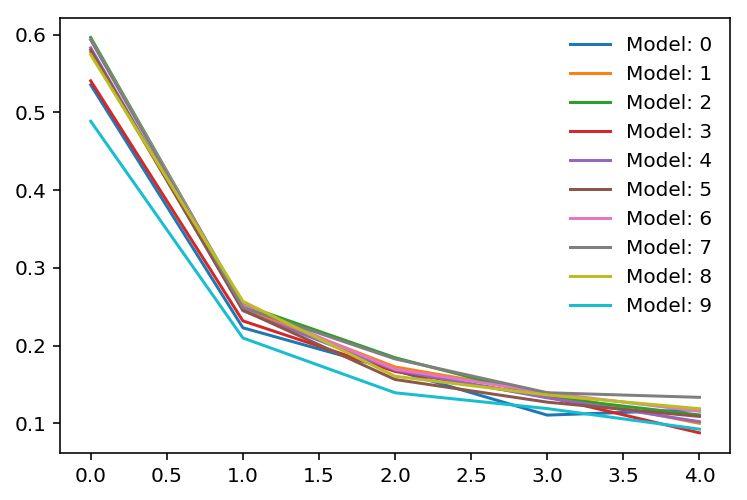

In [15]:
for i in range(NUM_TEACHERS):
    print('Model:',i)
    train_losses = train_model(trainloaders[i],models[i],5)
    line_label = "Model: {}".format(i)
    plt.plot(train_losses, label=line_label)
    plt.legend(frameon=False)

## Get predictions from 10 teacher models

Out of interest, I am also printing the accuracy on the test set, but we are not really using this, as we are treating this as an unlabelled dataset

In [0]:
def predictions (model, testloader):

    preds = torch.zeros([0, 0], dtype=torch.float32)
    accuracy = 0
    with torch.no_grad():
        for images, labels in testloader:
            log_ps = model(images)

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))
            if preds.shape[0]:
                preds = torch.cat((preds,top_class),0)
            else:
                preds = top_class

    print(accuracy / len(testloader))
    return preds
    

In [17]:
all_preds = torch.zeros([0, 0], dtype=torch.float32)
for i in range(NUM_TEACHERS):
    preds = predictions(models[i],testloader)
    if all_preds.shape[0]:
        all_preds = torch.cat((all_preds,preds),1)
    else:
        all_preds = preds

tensor(0.9326)
tensor(0.9235)
tensor(0.9333)
tensor(0.9180)
tensor(0.9283)
tensor(0.9174)
tensor(0.9249)
tensor(0.9295)
tensor(0.9234)
tensor(0.9228)


In [0]:
all_preds = torch.t(all_preds)

The teacher models appear to have high agreement on the test set

In [19]:
all_preds[:,0:20]

tensor([[7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4],
        [7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4],
        [7, 2, 1, 0, 4, 1, 4, 3, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4],
        [7, 2, 1, 0, 4, 1, 4, 9, 0, 9, 0, 6, 9, 0, 1, 3, 9, 7, 3, 4],
        [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 8, 9, 0, 1, 5, 9, 7, 8, 4],
        [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 7, 0, 1, 5, 9, 7, 3, 4],
        [7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4],
        [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4],
        [7, 2, 1, 0, 4, 1, 4, 4, 4, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4],
        [7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4]])

## Get the maximum noisy vote

What should the Laplacian scaling be??

b = sensitivity(query) / epsilon

query is the number of models agreeing on a label? so maximum change from removing one model is 1?

epsilon set to 1?

In [20]:
all_counts = np.zeros((10,(len(test_targets))))
all_counts_noise = np.zeros((10,(len(test_targets))))
lap_scale = 1

for i in range(len(test_targets)):
  counts = np.bincount(all_preds[:,i],minlength=10)
  all_counts[:,i] = counts
  for j in range(len(counts)):
    counts[j] += np.random.laplace(loc=0.0, scale=float(lap_scale))
  all_counts_noise[:,i] = counts
query_result = np.argmax(all_counts, axis=0)
agreement = np.max(all_counts, axis=0)
query_result_noise = np.argmax(all_counts_noise, axis=0)
agreement_noise = np.max(all_counts_noise, axis=0)
print("Average number of the models agreeing on label: ",np.mean(agreement))
print("Minimum number of the models agreeing on label: ", np.min(agreement))
print("Average number of the models agreeing on label (with noise): ",np.mean(agreement_noise))
print("Minimum number of the models agreeing on label (with noise): ", np.min(agreement_noise))

Average number of the models agreeing on label:  9.3926
Minimum number of the models agreeing on label:  3.0
Average number of the models agreeing on label (with noise):  8.9612
Minimum number of the models agreeing on label (with noise):  1.0


In [21]:
np.mean(query_result == query_result_noise)

0.9828

## Train the student model on the new results

Train the student model on the first 1000 examples of the test set, with labels from the teacher models with noise

In [0]:
def train_student_model (trainloader, model, epochs, test_labels):

    optimizer = optim.Adam(model.parameters(), lr=0.003)
    criterion = nn.NLLLoss()

    train_losses = []
    for e in range(epochs):
        running_loss = 0
        label_index = 0
        for images, labels in trainloader:
            new_labels = test_labels[label_index*STUDENT_BATCH_SIZE:label_index*STUDENT_BATCH_SIZE+STUDENT_BATCH_SIZE]
            label_index = label_index + 1
              
            if (label_index<(STUDENT_SET_SIZE / STUDENT_BATCH_SIZE)):
              log_ps = model(images)
              #loss = criterion(log_ps, labels)
              loss = criterion(log_ps, new_labels)

              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

            running_loss += loss.item()
        else:
            print(f"Training loss: {running_loss}")
            train_losses.append(running_loss/len(trainloader))
    return train_losses

Training loss: 104.20983934402466
Training loss: 41.771895945072174
Training loss: 37.86617128551006
Training loss: 52.620762556791306
Training loss: 21.656048625707626


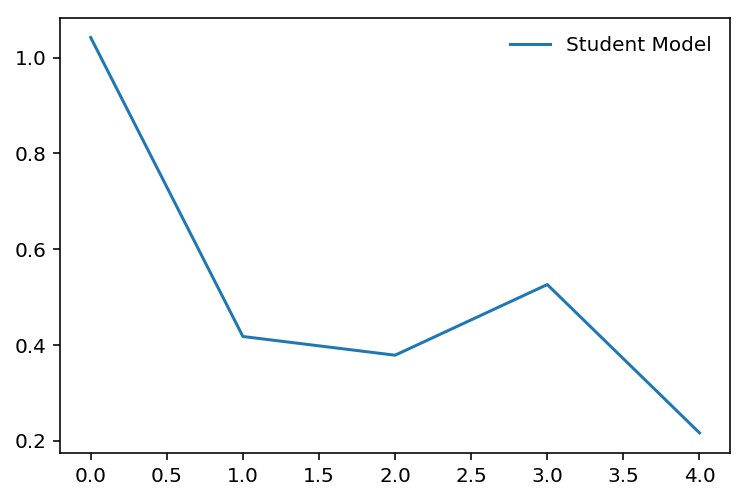

In [23]:
student_model = Classifier()
train_losses = train_student_model(testloader,student_model,5,torch.LongTensor(query_result_noise))
line_label = "Student Model"
plt.plot(train_losses, label=line_label)
plt.legend(frameon=False)    

## Perform PATE analysis

Perform a PATE analysis on the 1000 queries of the teacher models used to create the student training set.

Get the predictions for the second half of the test set, and check the accuracy of the student model on the remainder of the test set.

I am doing the analysis using the teacher models predictions used to train the student model, with the full set of predictions as the teacher_preds and the noisy max result as the indices.

The accuracy of the student model is quite low at 85%, which is presumably why in the paper they use a GAN instead of a standard network.

The data dependent epsilon is close to the data independent epsilon due to the small number of teachers, even though the teacher models agree on most of the examples.


In [0]:
def student_predictions (model, testloader, test_labels):

    preds = torch.zeros([0, 0], dtype=torch.float32)
    accuracy = 0
    true_accuracy = 0
    with torch.no_grad():
        label_index = 0
        for images, labels in testloader:
            new_labels = test_labels[label_index*100:label_index*100+100]
            label_index = label_index + 1
              
            if (label_index>(STUDENT_SET_SIZE / STUDENT_BATCH_SIZE)):
              log_ps = model(images)

              ps = torch.exp(log_ps)
              top_p, top_class = ps.topk(1, dim=1)
              equals = top_class == new_labels.view(*top_class.shape)
              accuracy += torch.mean(equals.type(torch.FloatTensor))
              true_equals = top_class == labels.view(*top_class.shape)
              true_accuracy += torch.mean(true_equals.type(torch.FloatTensor))
              if preds.shape[0]:
                  preds = torch.cat((preds,top_class),0)
              else:
                  preds = top_class

    print(true_accuracy / (len(testloader) - (STUDENT_SET_SIZE / STUDENT_BATCH_SIZE)))
    return preds
    

In [25]:
preds = student_predictions(student_model,testloader,torch.LongTensor(query_result_noise))

tensor(0.8567)


In [26]:
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=all_preds[:,0:1000], indices=query_result_noise[0:1000], noise_eps=0.1, delta=1e-5)
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

Data Independent Epsilon: 51.51292546497024
Data Dependent Epsilon: 51.512925464969555
